# Regression 

In [1]:
import jax.numpy as np
import jax
from matplotlib import pyplot as plt
from jax.lib import xla_bridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import ADAMLL as ada
from ADAMLL.activations import relu, sigmoid, eye
print("jax backend {}".format(xla_bridge.get_backend().platform))

jax backend gpu


## Data

In [2]:
n = 32  # Number of rows
m = 32  # Number of columns
perlin_noise_map = ada.generate_perlin_noise(n, m, seed=9999, scale=0.06) + jax.random.normal(jax.random.PRNGKey(2024), (n, m)) * 0.07

def simplerFunction(x):
    return 0.2*x + 0.8*x**2 + 2*x**3


x shape: (1024, 2)
t shape: (1024, 1)


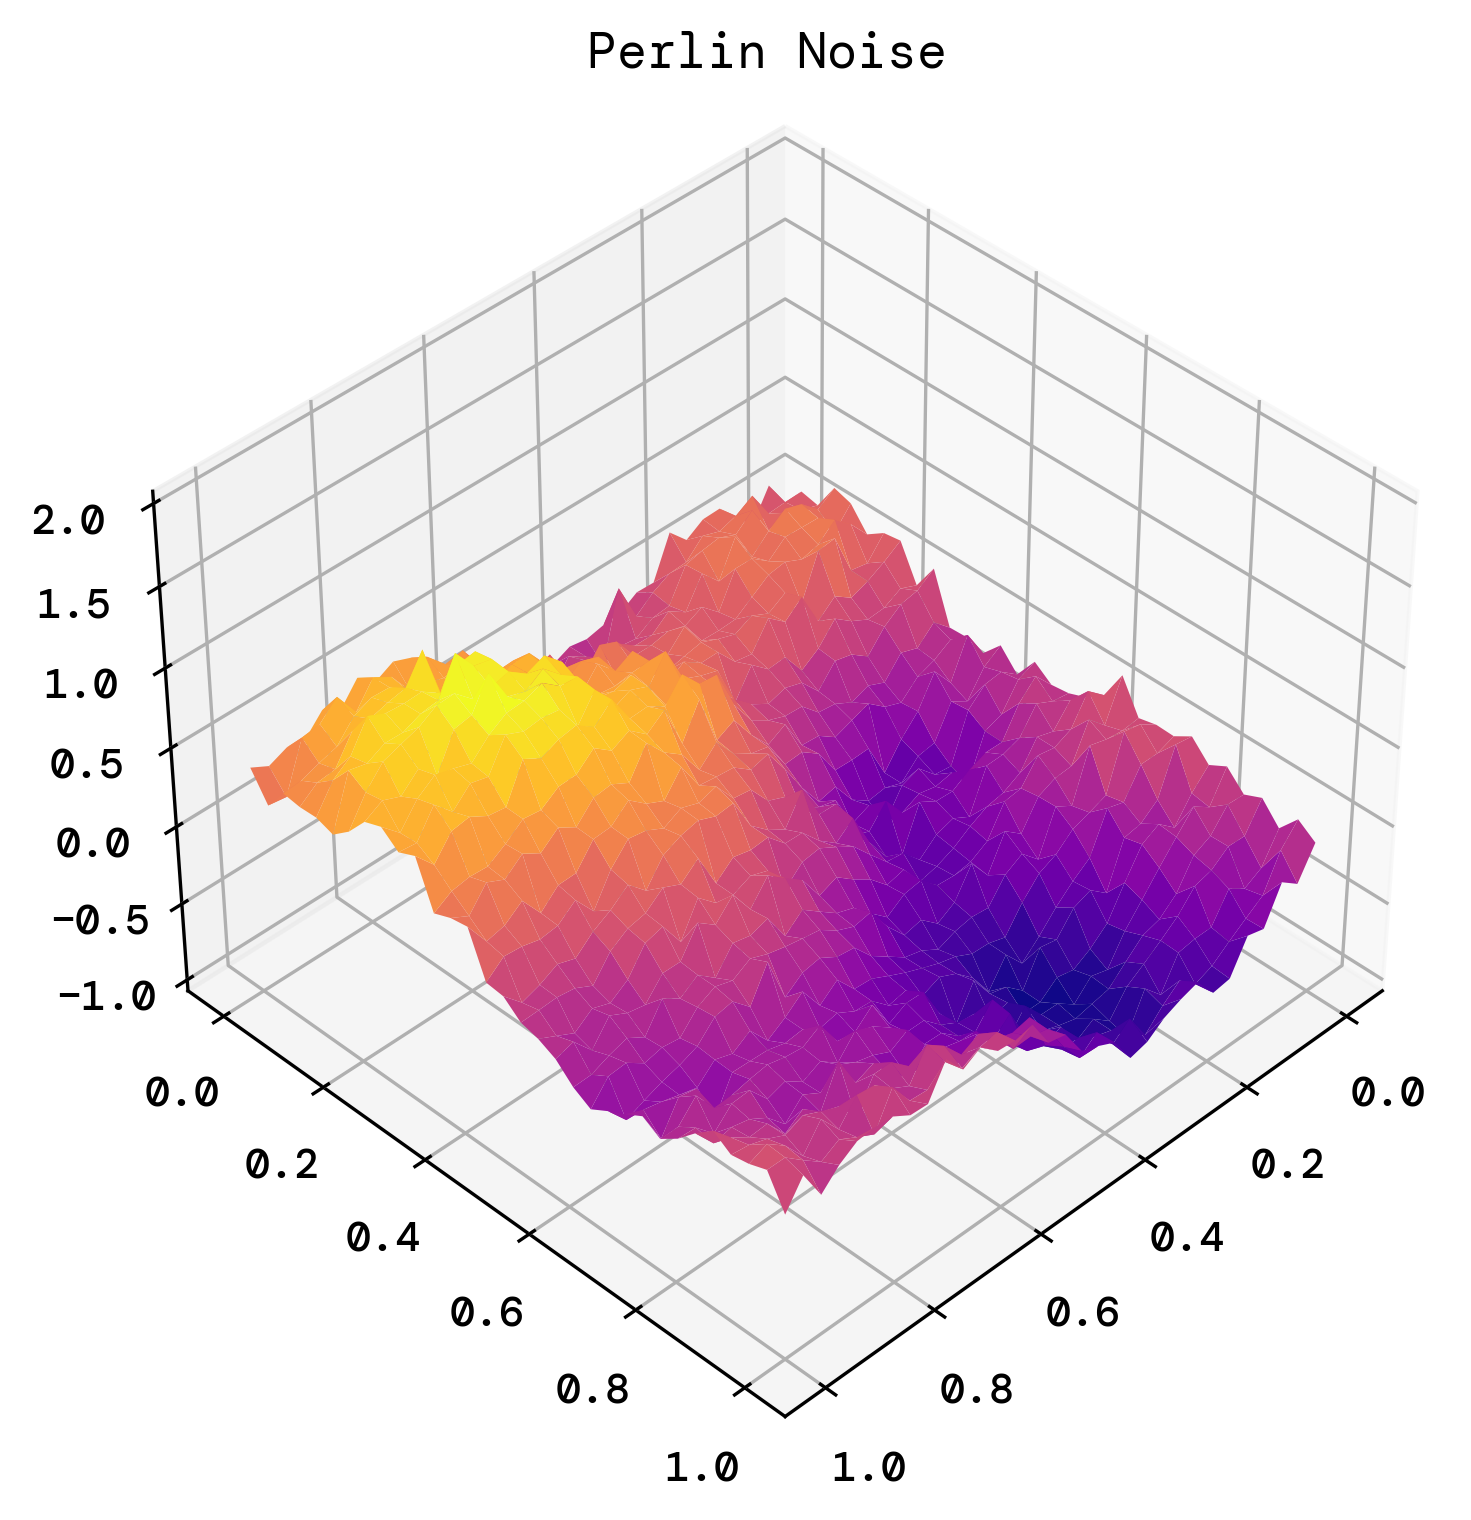

In [3]:
x = np.linspace(0, 1, 32)
y = np.linspace(0, 1, 32)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, perlin_noise_map, cmap='plasma',
                       linewidth=0, antialiased=True)
# fig.colorbar(surf, shrink=0.5, aspect=5)
fig.tight_layout()
ax.set_title("Perlin Noise")
ax.set_zlim(-1.01, 2.01)
ax.view_init(40, 45)
plt.savefig("../runsAndFigures/perlinNoise.png",bbox_inches='tight')


x = np.vstack([X.ravel(), Y.ravel()]).T
y = perlin_noise_map.reshape(-1, 1)

# ax.scatter(x[:, 0], x[:, 1], y, c=y.ravel(), cmap='plasma')
print("x shape: {}".format(x.shape))
print("t shape: {}".format(y.shape))

## Preprocessing

In [4]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

# Analysis

In [5]:
etas = [ 0.0001, 0.001, 0.01, 0.1  ]
epochs =200
tol = 0.001
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0]
epsilon = 1e-8
gammas = [0.0, 0.1, 0.5, 0.9]
decay = 0.9
beta1 = 0.9
beta2 = 0.999

poly = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)


def runGD():
    scoresSgd = np.zeros((len(etas), len(gammas),epochs))
    for i, eta in enumerate(etas):
        for j, gamma in enumerate(gammas):
            sgd     =  ada.NN.Model([[1,eye]], eta=eta, epochs=epochs, tol=tol, gamma=gamma , alpha=0, optimizer="sgd", loss=ada.MSE, metric=ada.MSE) 
            loss, _ = sgd.fit(X_train_poly, y_train, X_test_poly, y_test)
            scoresSgd = scoresSgd.at[i,j,:].set(loss)
            print(ada.progress_bar(i*len(gammas) + j, len(etas)*len(gammas)))
    return scoresSgd



In [6]:
scoresSgd = runGD()

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [>                   ] 6%
Training stopped after 199 epochs                                     Progress: [->                  ] 12%
Training stopped after 199 epochs                                     Progress: [-->                 ] 18%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [----->              ] 31%
Training stopped after 199 epochs                                     Progress: [------>             ] 37%
Training stopped after 199 epochs                                     Progress: [------->            ] 43%
Training stopped after 199 epochs                                     Progress: [--------->          ] 50%
Training stopped after 199 epochs      

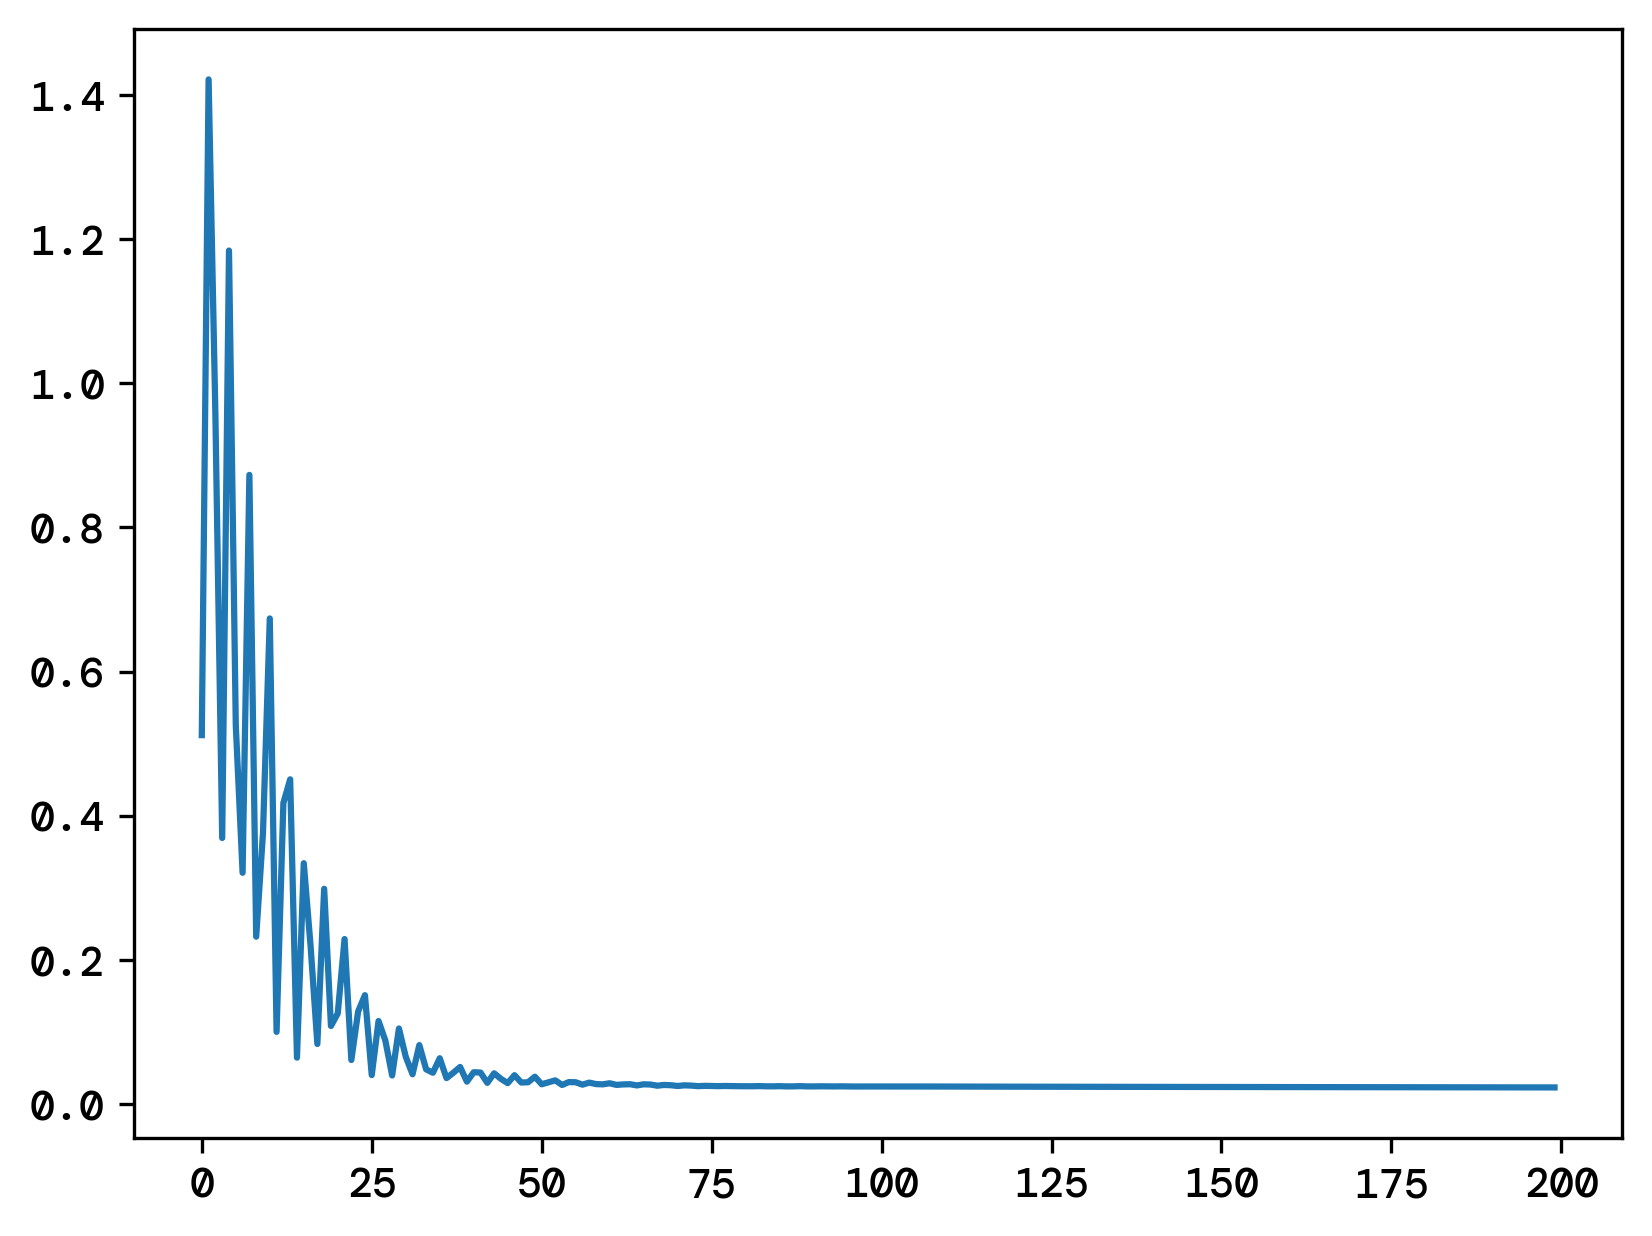

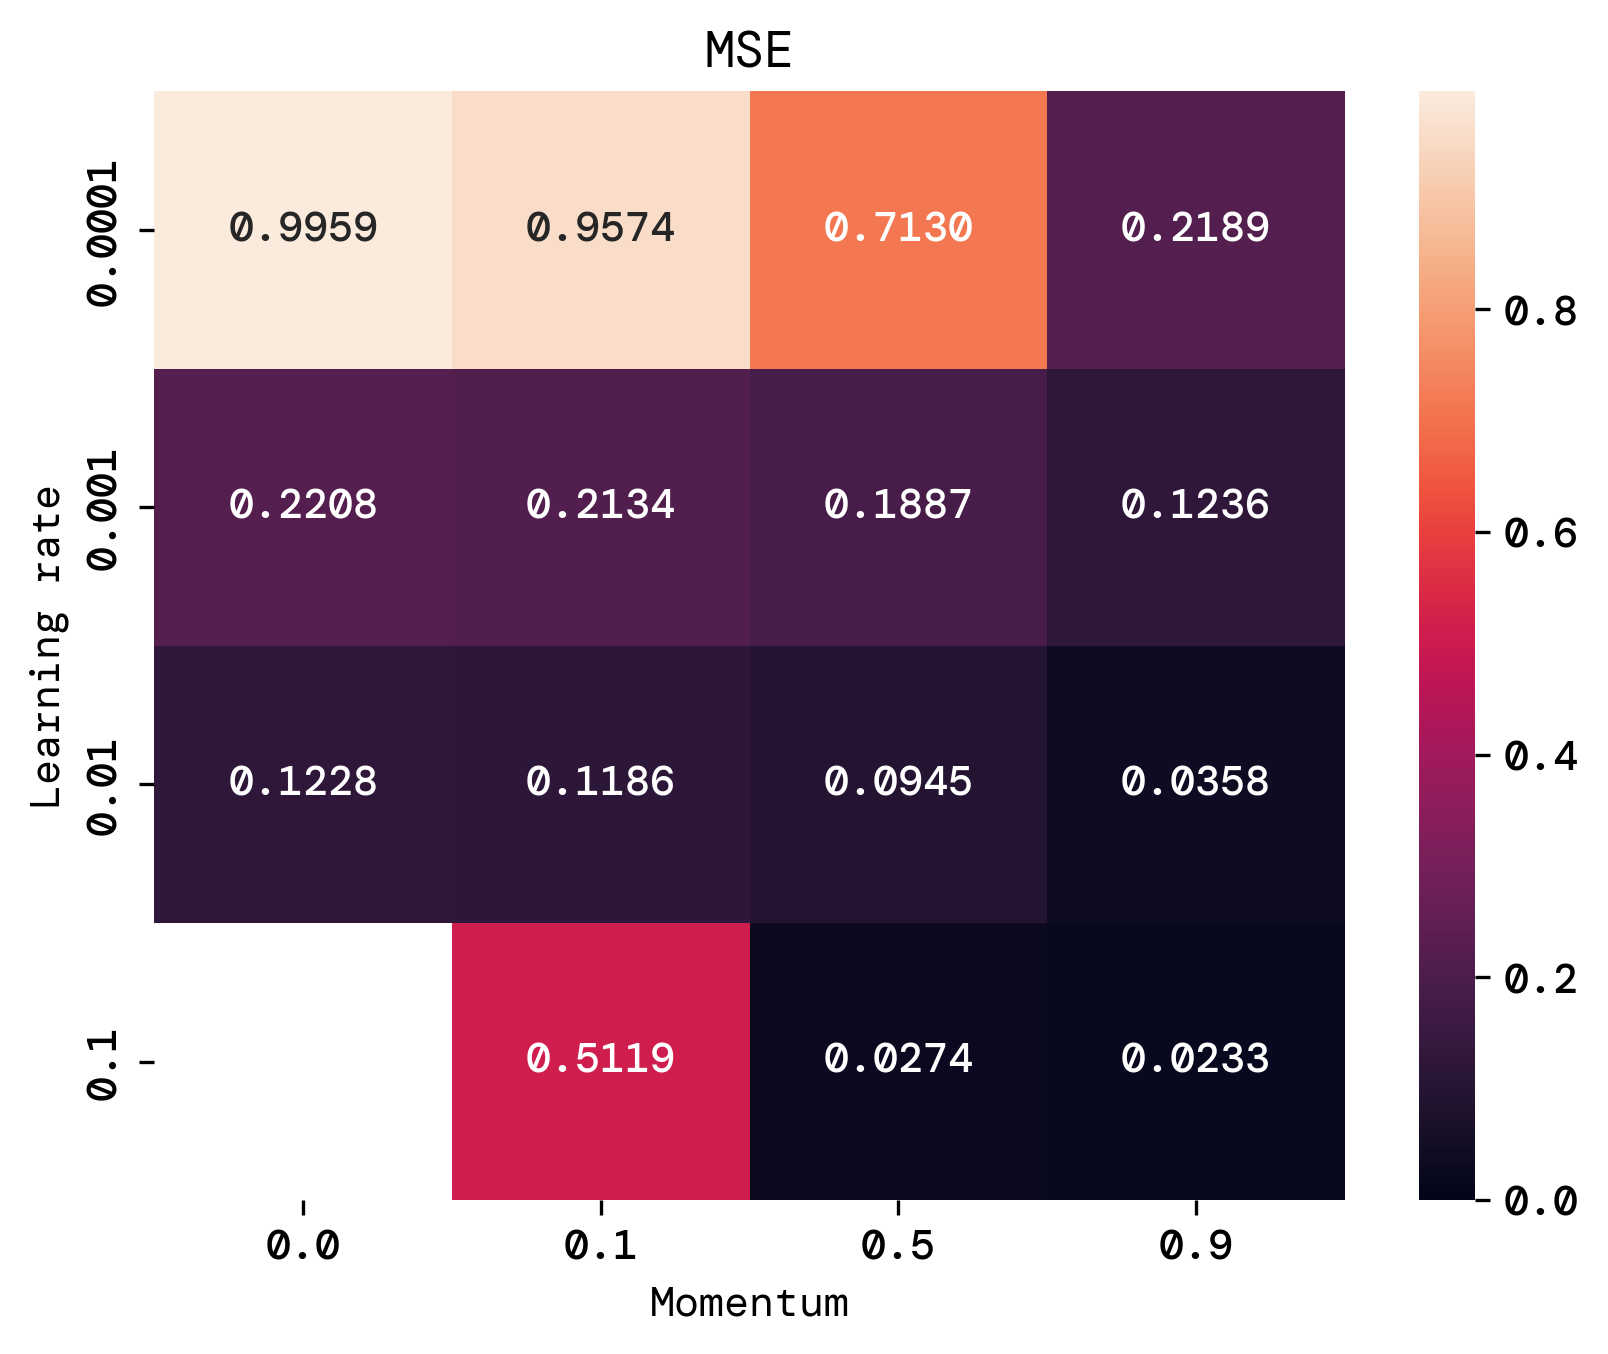

In [7]:
import seaborn as sns


fig, ax = plt.subplots(1, 1)
ax.plot(scoresSgd[3,3,:])

plt.figure()
ax = sns.heatmap(np.min(scoresSgd,axis=2), annot=True, fmt=".4f", vmin=0.0)
ax.set_title("MSE")
ax.set_xlabel("Momentum")
ax.set_xticklabels(gammas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(etas)
plt.savefig("../runsAndFigures/MSE_lr_gamma.png",bbox_inches='tight')
plt.show()



In this case havving momentum seems to be beneficial. We maxes out our testing range and found that 0.9 was the best value for momentum. momentum allows a higher learning rate

## Regularization

In [8]:
alphas = [0, 0.0001, 0.001, 0.01, 0.1]
kfold = KFold(8)
scores_ridge = np.zeros((len(alphas), kfold.get_n_splits()) )
for i, alpha in enumerate(alphas):
    k = 0
    for train_ind, val_ind in kfold.split(X_train_poly):
        ridge = ada.NN.Model([[1,eye]], eta=0.1, epochs=200, tol=tol, gamma=0.9 , alpha=alpha , optimizer="sgd", loss=ada.MSE, metric=ada.MSE) 
        ridge.fit(X_train_poly[train_ind], y_train[train_ind], X_train_poly[val_ind], y_train[val_ind])
        out = ridge.predict(X_train_poly[val_ind])
        scores_ridge = scores_ridge.at[i,k].set(ridge.metric(out, y_train[val_ind]))
        k += 1
    print(ada.progress_bar(i, len(alphas)))

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [--->                ] 20%
Training stopped after 199 epochs                                     Progress: [------->            ] 40%
Training stopped after 199 epochs                                     Progress: [----------->        ] 60%
Training stopped after 199 epochs                                     Progress: [--------------->    ] 80%


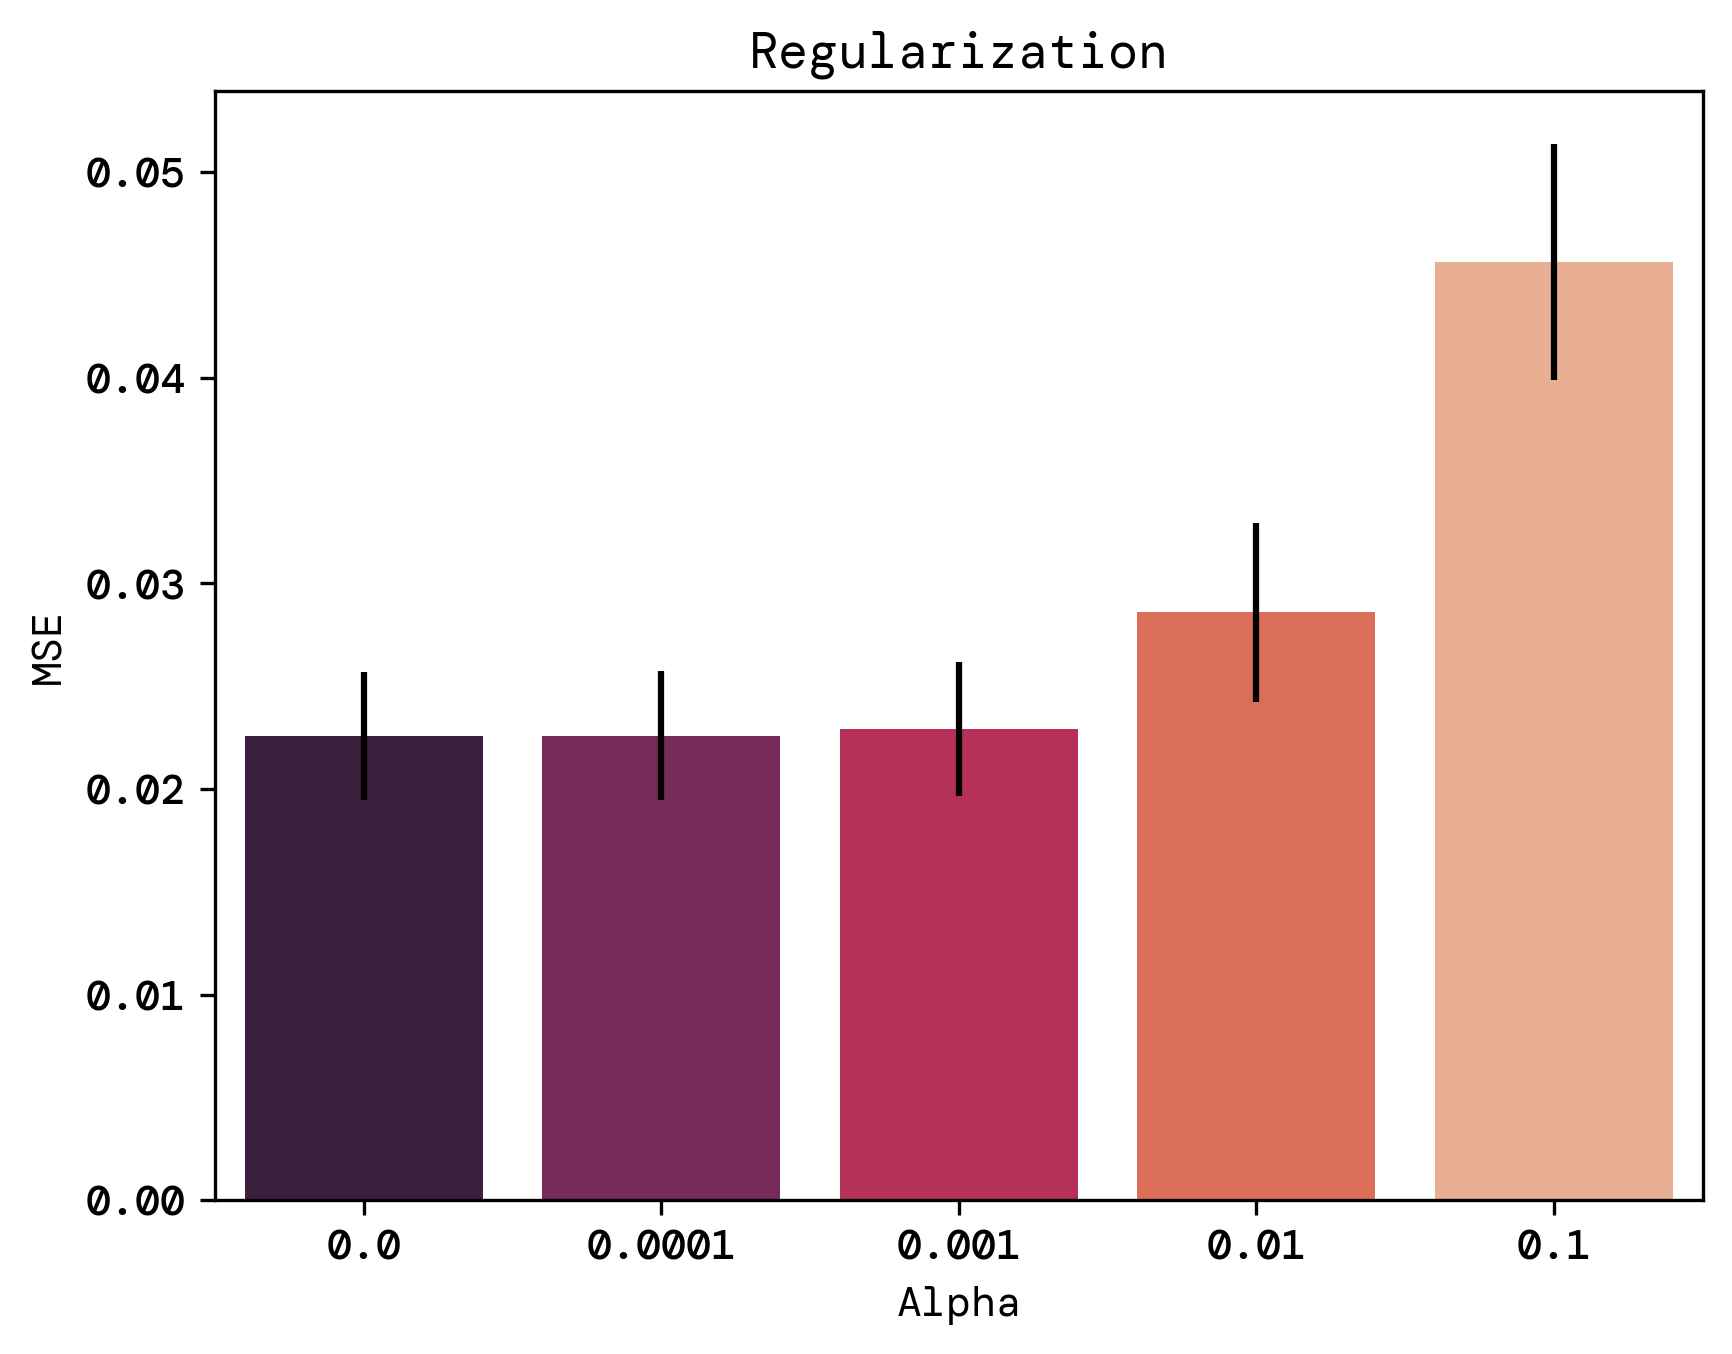

In [9]:
ax = sns.barplot(x=alphas, y=np.mean(scores_ridge, axis=1), yerr=np.std(scores_ridge, axis=1), palette="rocket")
ax.set_title("Regularization")
ax.set_xlabel("Alpha")
ax.set_ylabel("MSE")
plt.savefig("../runsAndFigures/MSE_alpha.png",bbox_inches='tight')


X_train_poly shape: (819, 20)
Training stopped after 199 epochs                                     

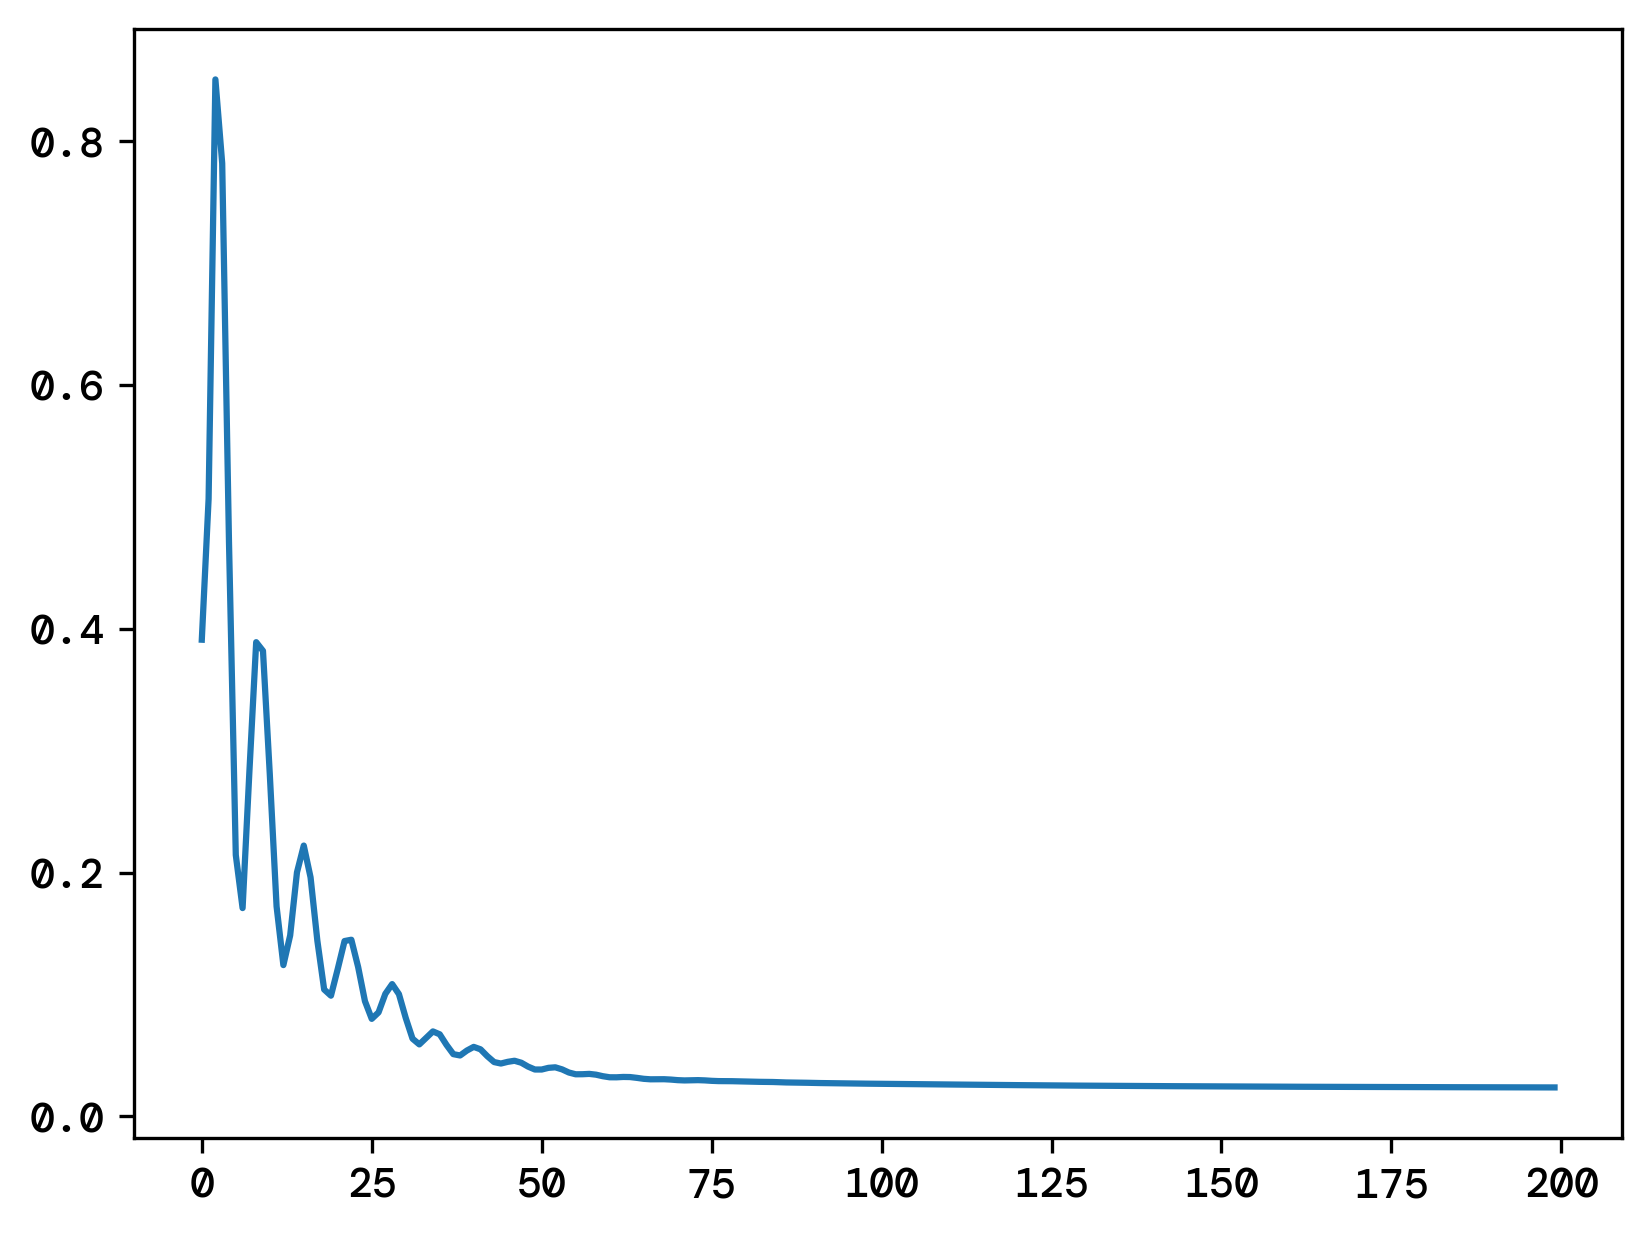

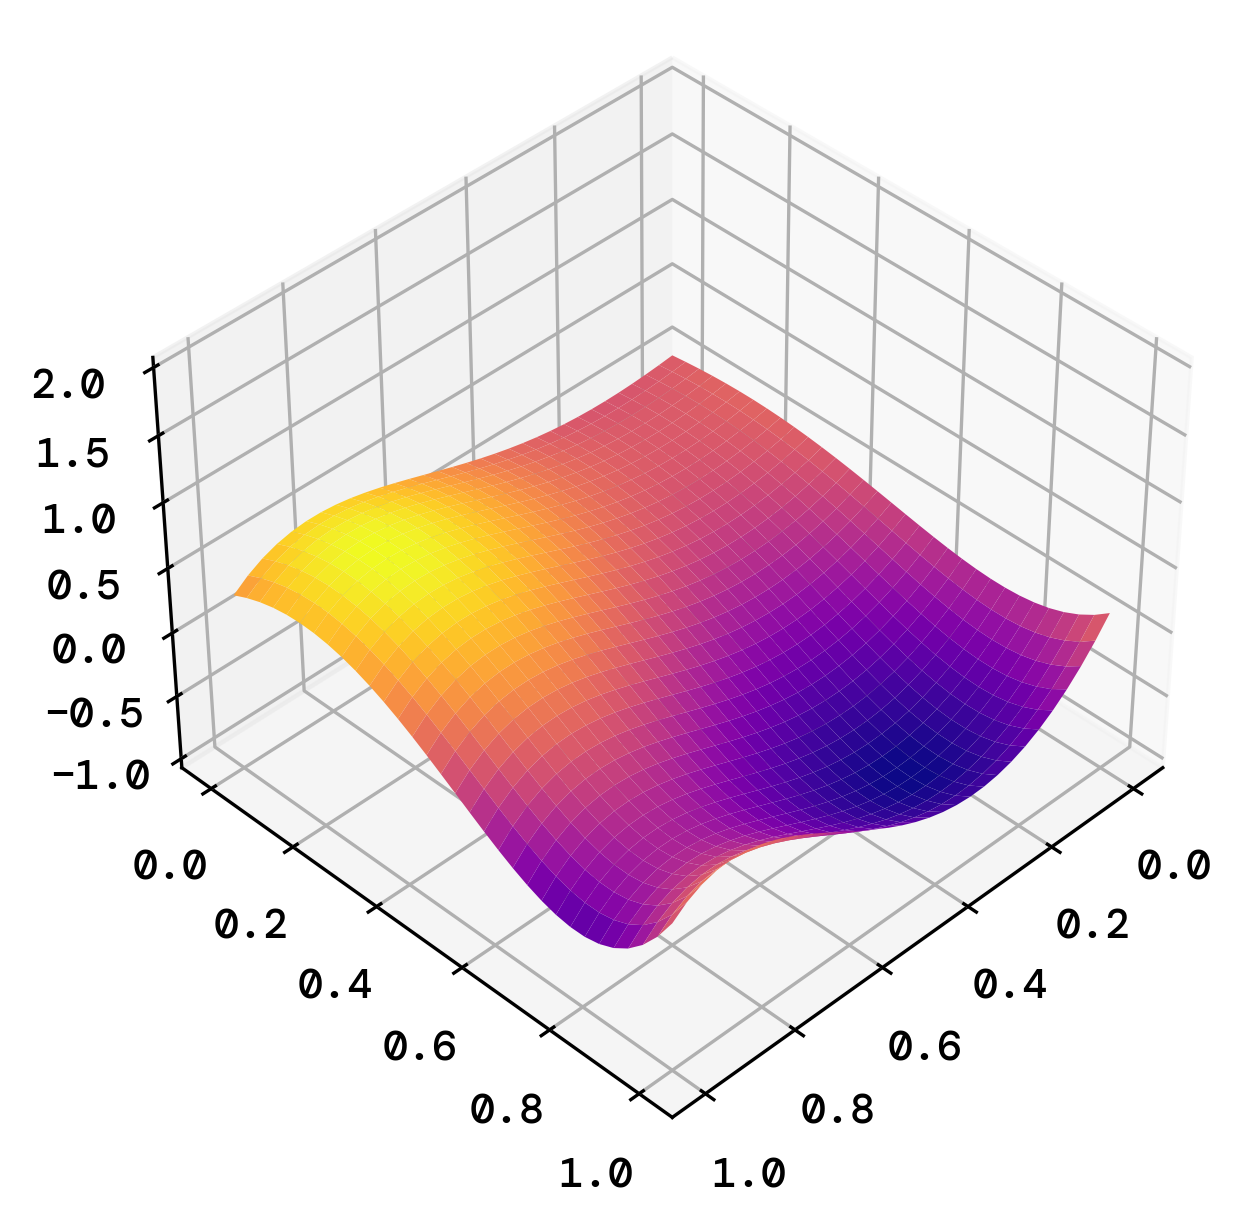

In [10]:
# plot predictions
poly = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)


print("X_train_poly shape: {}".format(X_train_poly.shape))

      
model = ada.NN.Model([[1,eye]], eta=0.1, epochs=200, tol=tol, alpha=0, gamma=0.5, optimizer="adam", loss=ada.MSE, metric=ada.MSE)

loss, params = model.fit(X_train_poly, y_train, X_test_poly, y_test)

y_pred = model.predict(scaler.transform(poly.transform(x)))


fig, ax = plt.subplots(1, 1)
ax.plot(loss)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, y_pred.reshape(32,32), cmap='plasma',
                       linewidth=0, antialiased=True)
ax.set_zlim(-1.01, 2.01)
ax.view_init(40, 45)





# Automatic differentiation

Training stopped after 99 epochs                                      auto vs manual
auto {'b': Array([0.24602726], dtype=float32), 'w': Array([[ 0.4130881 ],
       [-0.94576377]], dtype=float32)}
manual {'b': Array([0.24602732], dtype=float32), 'w': Array([[ 0.4130881],
       [-0.9457639]], dtype=float32)}


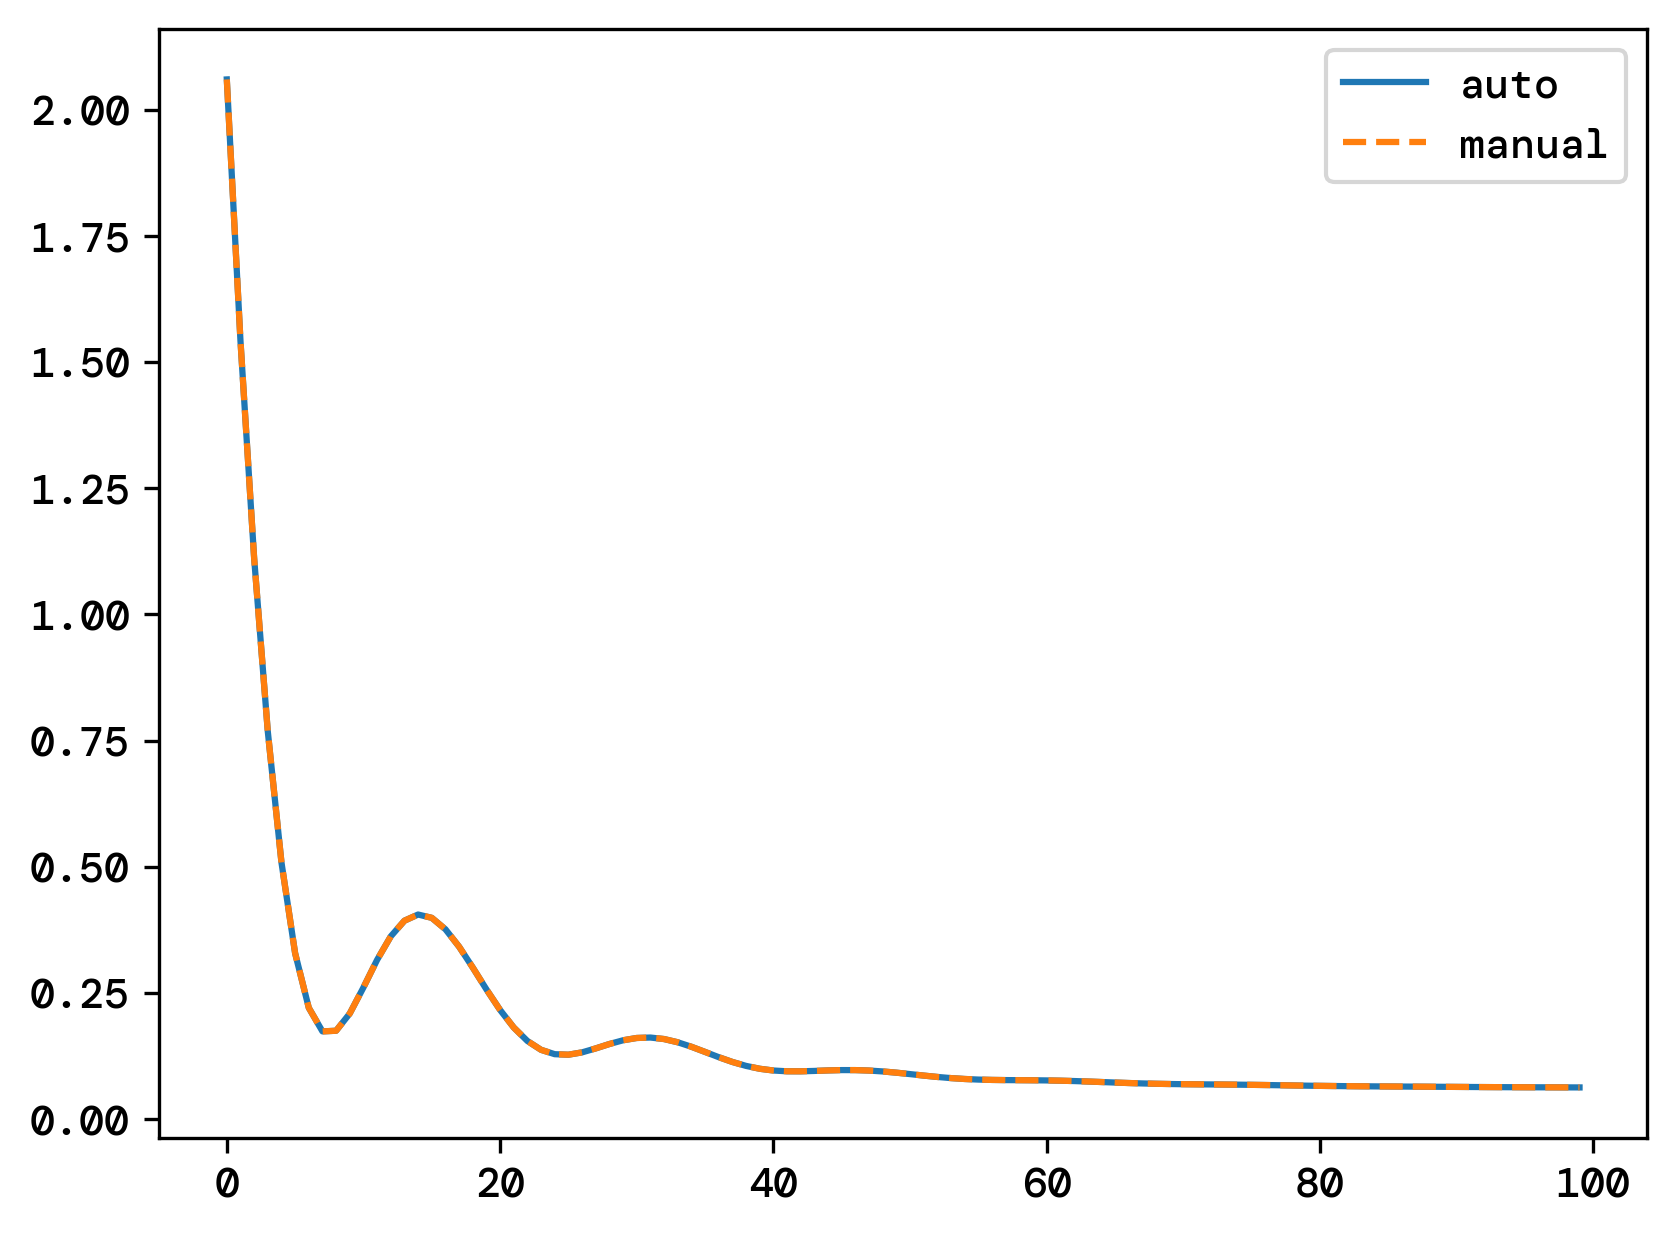

In [11]:
auto = ada.NN.Model([[1,eye]], eta=0.1, epochs=100, tol=tol , alpha=0,optimizer="adam", loss=ada.MSE, metric=ada.MSE)
manual = ada.NN.Model([[1,eye]], eta=0.1, epochs=100, tol=tol , backwards=ada.NN.backwards_no_hidden, alpha=0, optimizer="adam", metric=ada.MSE)

lossAuto, params_auto = auto.fit(X_train, y_train, X_test, y_test)
lossManual, params = manual.fit(X_train, y_train, X_test, y_test)

plt.figure()
plt.plot(lossAuto,label="auto")
plt.plot(lossManual,"--", label="manual")
plt.legend()
print("auto vs manual")
print("auto",params_auto[0])
print("manual",params[0])

## Optimizers

In [ ]:
network = ada.NN.Model([[1, sigmoid]], 0.01 , 100 ,tol, 'adam', 0.0001 , 0.9, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
network.fit(X_train,y_train, X_test, y_test, batch_size=batch_size)
adam_accuracy = ada.accuracy(network.classify(X_test), y_test)
network = ada.NN.Model([[1, sigmoid]], 0.01 , 100 ,tol, 'adagrad', 0.0001 , 0.9, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
network.fit(X_train,y_train, X_test, y_test, batch_size=batch_size)
adagrad_accuracy = ada.accuracy(network.classify(X_test), y_test)
network = ada.NN.Model([[1, sigmoid]], 0.01 , 100 ,tol, 'rmsprop', 0.0001 , 0.9, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
network.fit(X_train,y_train, X_test, y_test, batch_size=batch_size)
rmsprop_accuracy = ada.accuracy(network.classify(X_test), y_test)
network = ada.NN.Model([[1, sigmoid]], 0.01 , 100 ,tol, 'sgd', 0.0001 , 0.9, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
network.fit(X_train,y_train, X_test, y_test, batch_size=batch_size)
sgd_accuracy = ada.accuracy(network.classify(X_test), y_test)



optimizer_accuracy = onp.array([adam_accuracy, adagrad_accuracy, rmsprop_accuracy, sgd_accuracy])
adam_accuracy = np.round(adam_accuracy, 3)
rmsprop_accuracy = np.round(rmsprop_accuracy, 3)
adagrad_accuracy = np.round(adagrad_accuracy, 3)
sgd_accuracy = np.round(sgd_accuracy, 3)
optimizer_names = ['adam', 'adagrad', 'rmsprop', 'sgd']
ax = sns.barplot(x=optimizer_names, y=optimizer_accuracy, palette="rocket")
ax.set_xlabel("optimizer")
ax.set_ylabel("accuracy")
ax.text(0, 0.5, f"{adam_accuracy:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.5, f"{adagrad_accuracy:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.5, f"{rmsprop_accuracy:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.5, f"{sgd_accuracy:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/optimizer_accuracy.png",bbox_inches='tight')
plt.show()

## Adding Layers

In [12]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training stopped after 199 epochs                                     loss: 0.010447693057358265


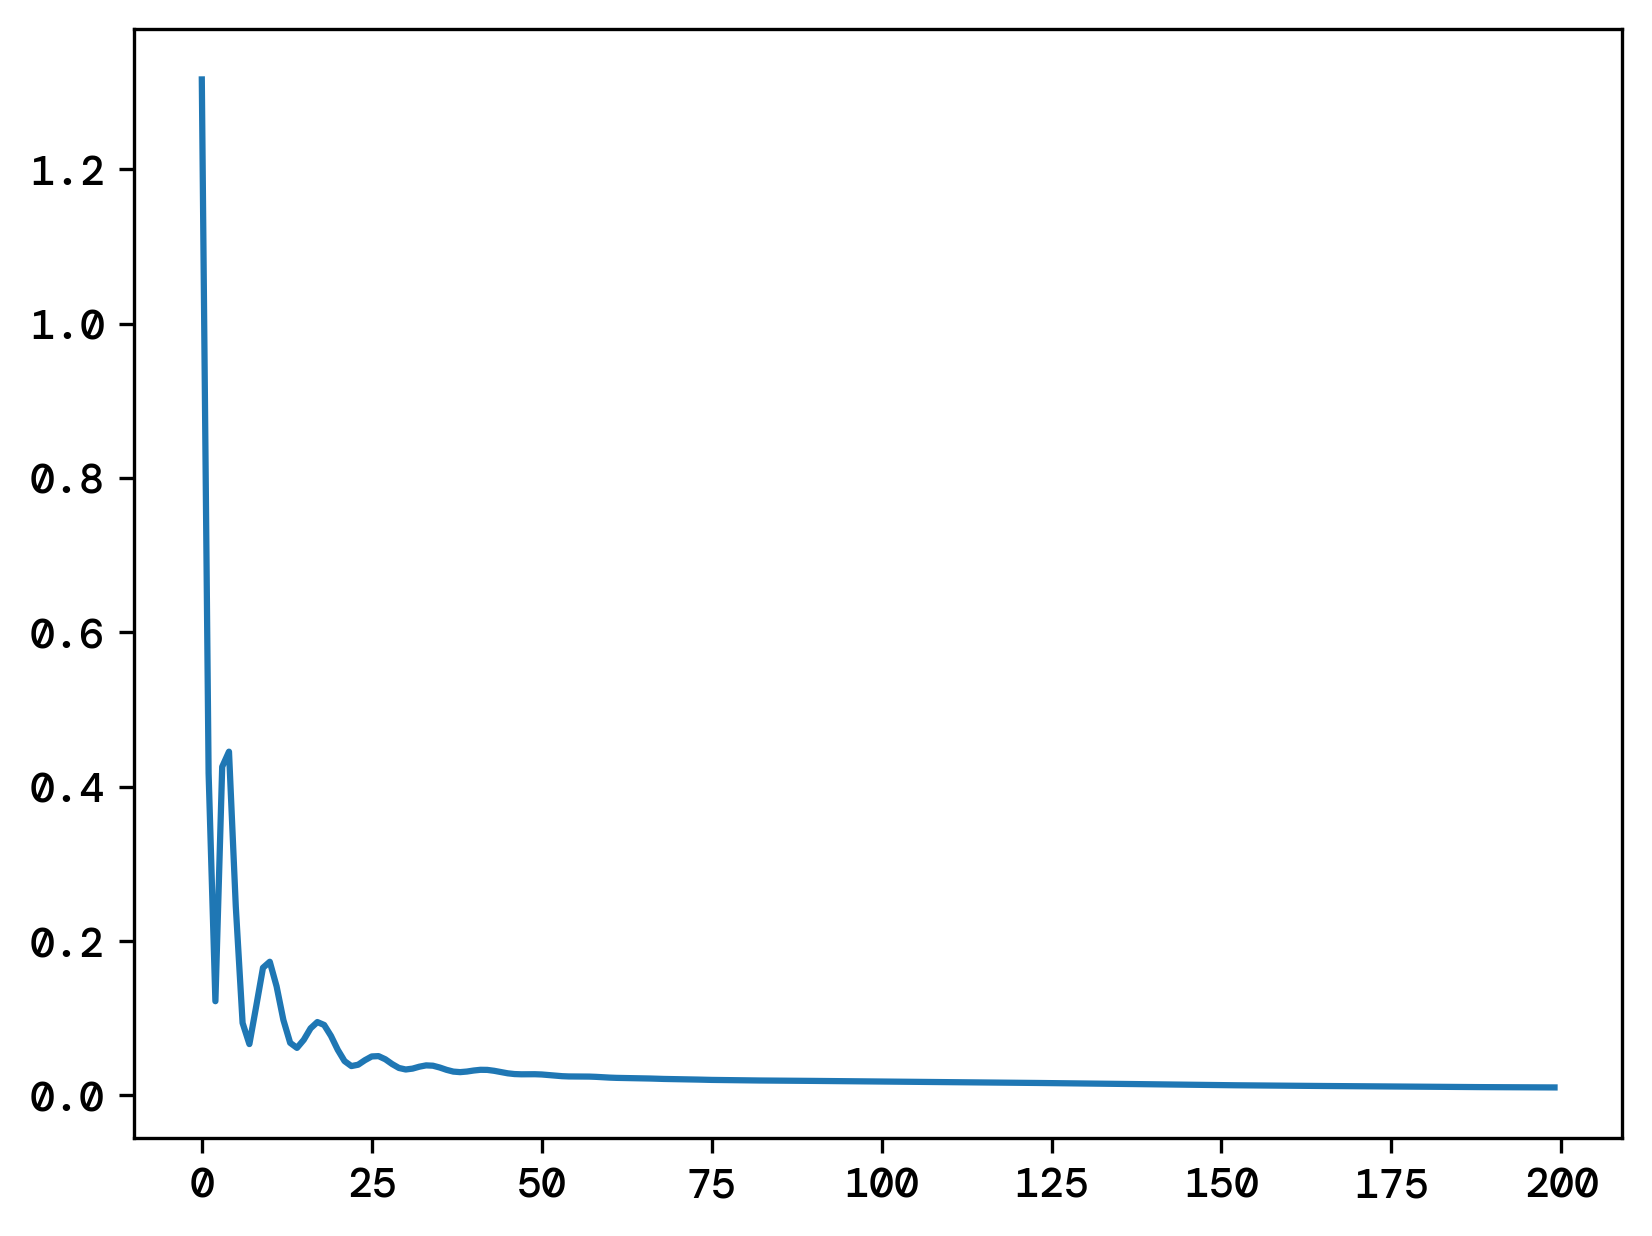

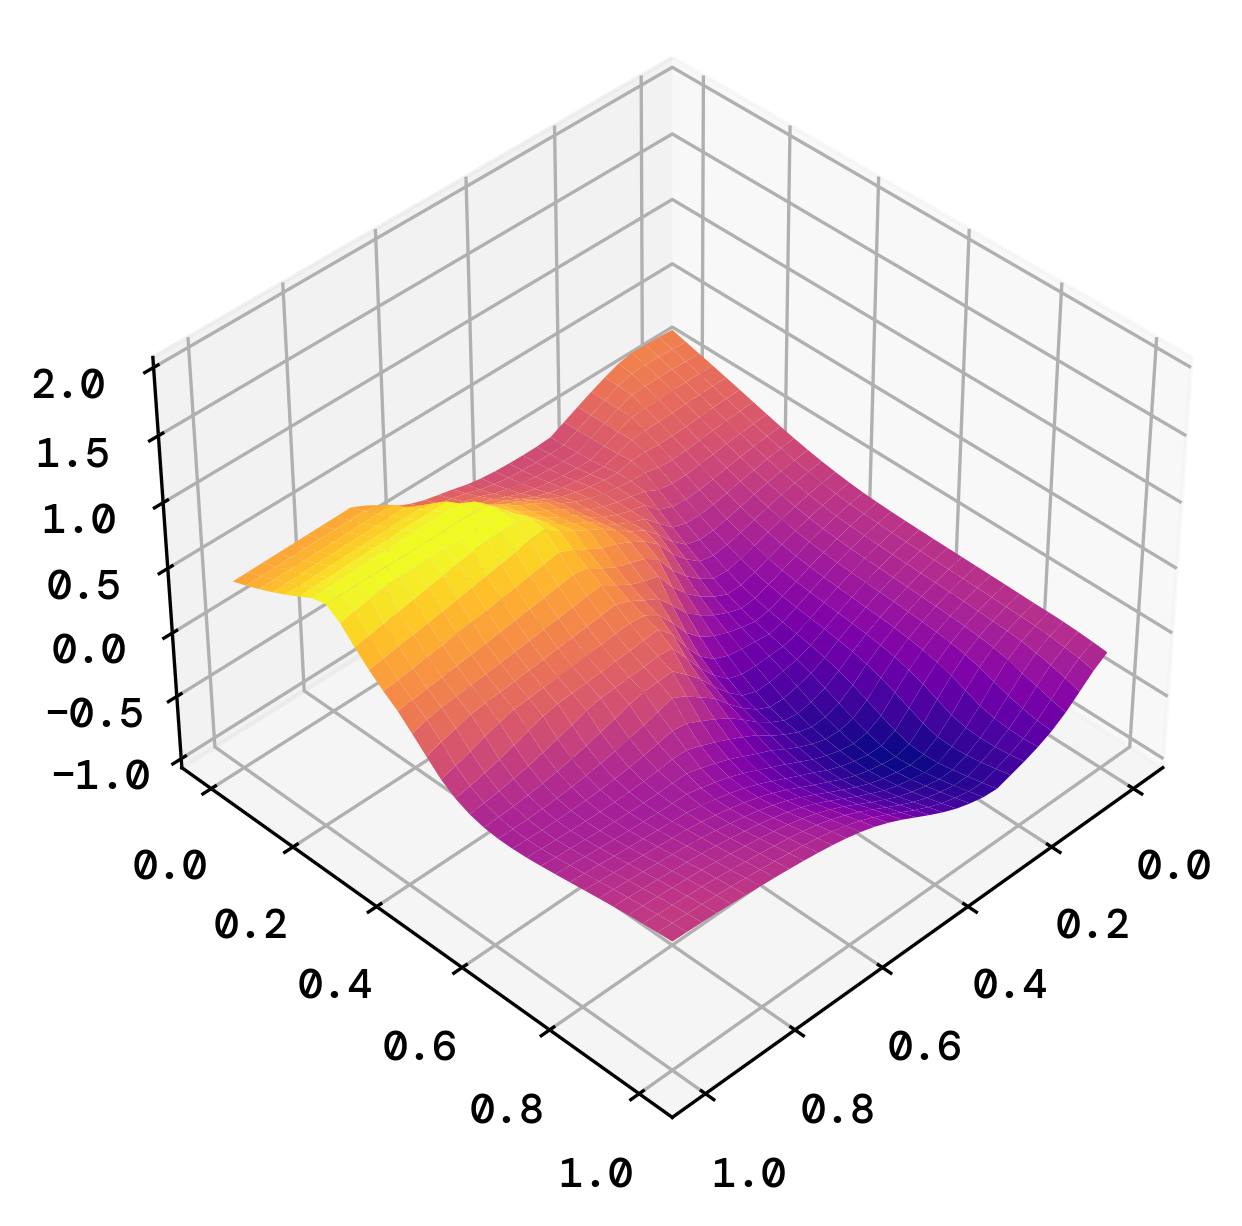

In [13]:



model = ada.NN.Model([[10,relu],[15,sigmoid],[1,eye]], eta=0.1, epochs=200, tol=tol, alpha=0, optimizer="adam", loss=ada.MSE, metric=ada.MSE)

loss, params = model.fit(X_train, y_train, X_test, y_test)

y_pred = model.predict(scaler.transform(x))
# y_pred = model.predict(x)

print("loss: {}".format(loss[-1]))
fig, ax = plt.subplots(1, 1)
ax.plot(loss)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, y_pred.reshape(32,32), cmap='plasma',
                       linewidth=0, antialiased=True)
ax.set_zlim(-1.01, 2.01)
ax.view_init(40, 45)

In this analysis every model seemed to have converged with the same final MSE, give or take. However 
we see that some models allows us to use a wider range of learning rates. This is especially true for the models with momentum. These new optimizers and auto differentiation is a new tool in our toolbox that we can use to optimize our models.